
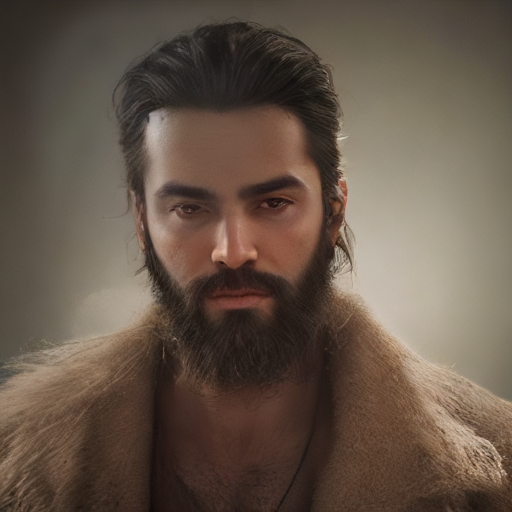

KeyboardInterrupt: 

In [1]:

import os, sys, io, runpy, base64, torch, importlib, collections, torchvision
from IPython.display import display, clear_output, HTML
import torchvision.transforms.functional as TF

CONFIG = 'eval_configs/19_final_tensorrt.yaml'
SCRIPT = 'test_demo_gen.py'
MAX_NAMES = 30
IMG_MAX_WIDTH = 512

import torchvision.utils as tvu
importlib.reload(tvu)
torchvision.utils = tvu
orig_save = torchvision.utils.save_image

name_buf = collections.deque(maxlen=MAX_NAMES)

def render(img_bytes: bytes, names):
    b64 = base64.b64encode(img_bytes).decode('utf-8')
    list_html = ''.join([f"<div>{n}</div>" for n in names])
    html = (
        "<div style='display:flex;align-items:flex-start;gap:16px;'>"
        f"<div><img style='max-width:{IMG_MAX_WIDTH}px;height:auto;' src='data:image/png;base64,{b64}'></div>"
        "<div style='font-family:monospace;white-space:pre;line-height:1.3;max-height:600px;overflow:auto;'>"
        "<div style='font-weight:bold;margin-bottom:4px;'>Latest Files</div>"
        f"{list_html}"
        "</div>"
        "</div>"
    )
    clear_output(wait=True)
    display(HTML(html))

def save_image_hook(tensor, fp, *args, **kwargs):
    orig_save(tensor, fp, *args, **kwargs)
    name_buf.appendleft(os.path.basename(str(fp)))
    try:
        img = tensor.detach().cpu()
        if img.dim() == 4:
            img = img[0]
        img = torch.clamp(img, 0, 1)
        pil = TF.to_pil_image(img)
        bio = io.BytesIO()
        pil.save(bio, format='PNG')
        render(bio.getvalue(), list(name_buf))
    except Exception as e:
        print('display error:', e)

torchvision.utils.save_image = save_image_hook

sys.argv = [SCRIPT, CONFIG]
runpy.run_path(SCRIPT)

